<a href="https://colab.research.google.com/github/greygrease/tf-stuff/blob/main/Tweet_Analysis_MultiModel_NN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Helper Functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-10-02 18:11:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-10-02 18:11:51 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback,compare_historys, plot_loss_curves, calculate_results

## Download and Import Dataset

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/kaggle_dataset'

In [6]:
%cd /content/gdrive/My Drive/kaggle_dataset

/content/gdrive/My Drive/kaggle_dataset


In [7]:
!kaggle datasets download -d kazanova/sentiment140

401 - Unauthorized


In [8]:
!mkdir sentiment140_unpacked
!mv sentiment140.zip sentiment140_unpacked

mkdir: cannot create directory ‘sentiment140_unpacked’: File exists
mv: cannot stat 'sentiment140.zip': No such file or directory


In [9]:
%cd sentiment140_unpacked/

/content/gdrive/MyDrive/kaggle_dataset/sentiment140_unpacked


In [10]:
# !unzip sentiment140.zip

## Create a pandas dataframe and preprocess the data



In [11]:
import pandas as pd

sentiment_df = pd.read_csv('/content/gdrive/MyDrive/kaggle_dataset/sentiment140_unpacked/training.1600000.processed.noemoticon.csv', encoding='latin-1')

In [12]:
sentiment_df = sentiment_df.drop(['Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY', '_TheSpecialOne_', '1467810369'], axis = 1)

In [13]:
sentiment_df.columns


Index(['0', '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'], dtype='object')

In [14]:
sentiment_df.rename(columns = {'0' : 'Label',
                               "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D" : 'Text'}, inplace = True)

In [15]:
sentiment_df.head()

,Label,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [16]:
first_col = sentiment_df.pop('Text')

In [17]:
sentiment_df.insert(0, 'Text', first_col)

In [18]:
sentiment_df.head()

,Text,Label
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [19]:
sentiment_df = sentiment_df.sample(frac = 1, random_state = 42)

In [20]:
sentiment_df

,Text,Label
541200,@Nkluvr4eva My poor little dumpling In Holmde...,0
750,I'm off too bed. I gotta wake up hella early t...,0
766711,I havent been able to listen to it yet My spe...,0
285055,now remembers why solving a relatively big equ...,0
705995,"Ate too much, feel sick",0
...,...,...
259178,I didn't. The link was wrong,0
1414414,@tommcfly yes!! mcfly twitter profile is an ex...,4
131932,@SarahFTW I know sometimes i just pretend i h...,0
671155,Cant believe you came and asked me that...,0


### Split data into `Train`, `Test` and `Validation`

### Split DataFrame to `trainval` and `test`

In [21]:
from sklearn.model_selection import train_test_split

trainval_sentences, test_sentences, trainval_labels, test_labels = train_test_split(sentiment_df['Text'].to_numpy(),
                                                                                    sentiment_df['Label'].to_numpy(),
                                                                                    test_size = 0.15,
                                                                                    random_state = 42)

### Split `trainval` to `train` and `validation`

In [22]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(trainval_sentences,
                                                                            trainval_labels,
                                                                            test_size = 0.15,
                                                                            random_state = 42)

In [23]:
len(train_sentences), len(train_labels)

(1155999, 1155999)

In [24]:
len(test_sentences), len(test_labels)

(240000, 240000)

In [25]:
len(val_sentences), len(val_labels)

(204000, 204000)

## Visualize our dataset

In [26]:
import random
rand_id = random.randint(0, len(sentiment_df)-10)
for row in sentiment_df[['Text', 'Label']][rand_id : rand_id + 10].itertuples():
  _, text, target = row
  print(f'Target : {target}', '[Positive]' if target ==  4 else '[Negative]')
  print(f'Text : {text}')
  print(f'-----\n')

Target : 4 [Positive]
Text : @thelonelyisland i love you guys! i have all ur songs and i love all ur vids ...&lt;3 bye 
-----

Target : 4 [Positive]
Text : Listening to the Jonas Brothers. 
-----

Target : 0 [Negative]
Text : my iPod touch keeps freezing 
-----

Target : 4 [Positive]
Text : cleaned house all day &amp; packed for the beach...now watchin' movies 
-----

Target : 4 [Positive]
Text : http://www.online-spiel.net/  thats it 
-----

Target : 4 [Positive]
Text : She is a McCoy fan too 
-----

Target : 4 [Positive]
Text : Bought a kite.Flew the kite.Shoes ruined.Boyfriend owes me a new pair of shoes (secret) i was getting sick of them  ..it was a worthy day.
-----

Target : 4 [Positive]
Text : ...if this works out well enough I might have enough momentum to launch it - officially. If not, it dies a quiet death. 
-----

Target : 0 [Negative]
Text : I want to eat away my feelings 
-----

Target : 4 [Positive]
Text : @E_IS_FRESH -- THANX FOR FOLLOWING. how are you..?? 
-----



### Converting `train`, `val`, `test` dataframes into datasets

In [27]:
frames_train = [pd.DataFrame(train_sentences), pd.DataFrame(train_labels)]
frames_val = [pd.DataFrame(val_sentences), pd.DataFrame(val_labels)]
frames_test = [pd.DataFrame(test_sentences), pd.DataFrame(test_labels)]

train_df = pd.concat(frames_train, axis = 1)
val_df = pd.concat(frames_val, axis = 1)
test_df = pd.concat(frames_test, axis = 1)

train_df.columns = ['Text', 'Label']
val_df.columns = ['Text', 'Label']
test_df.columns = ['Text', 'Label']

In [28]:
train_df.Label.value_counts()

4    578220
0    577779
Name: Label, dtype: int64

## Model_0 Getting a Baseline


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create the model
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the model
model_0.fit(X = train_sentences,
            y = train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate our Baseline Model
model_0.score(X = val_sentences,
              y = val_labels)

0.7705245098039216

In [31]:
baseline_preds = model_0.predict(val_sentences)

In [32]:
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)

In [33]:
RESULTS = {}
RESULTS['model_0'] = baseline_results

## Preparing data for Deep Sequence models

### Create Text Vectorizing and Embedding Layers

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [35]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [36]:
sent_lens[:10]

[26, 10, 5, 11, 18, 17, 5, 19, 26, 15]

In [37]:
average_sent_lens = np.mean(sent_lens)
average_sent_lens

13.174920566540283

(array([4.3110e+03, 1.8171e+04, 3.7588e+04, 4.9260e+04, 5.8573e+04,
        6.2983e+04, 6.4575e+04, 6.4328e+04, 6.2677e+04, 6.0320e+04,
        5.8087e+04, 5.4993e+04, 5.1852e+04, 4.8882e+04, 4.5791e+04,
        4.3271e+04, 4.0543e+04, 3.8841e+04, 3.7516e+04, 0.0000e+00,
        3.7210e+04, 3.4925e+04, 3.4475e+04, 3.2906e+04, 3.0753e+04,
        2.7020e+04, 2.1461e+04, 1.5368e+04, 9.6030e+03, 5.3220e+03,
        2.6050e+03, 1.1210e+03, 4.2000e+02, 1.6000e+02, 5.7000e+01,
        1.4000e+01, 5.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  , 20.95, 21.9

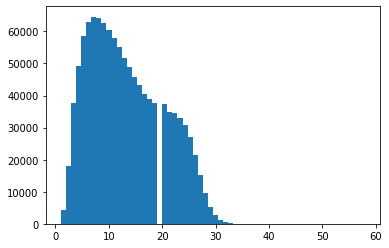

In [38]:
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins = 60)

In [39]:
output_seq_len = int(np.percentile(sent_lens, 98))
output_seq_len

27

### Create Text Vectorizer Layer

In [40]:
max_vocab_length = 120000

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = max_vocab_length,
                                                    output_sequence_length = output_seq_len)

In [41]:
# Adapt text vectorizer to train sentence

text_vectorizer.adapt(train_sentences)

In [42]:
# Test vectorizing layer

import random
target_sent = random.choice(train_sentences)
print(f'Target Sentence:\n {target_sent}')
print(f'Length of text: {len(target_sent)}')
print(f'After Vectorizing:\n {text_vectorizer([target_sent])}')

Target Sentence:
 feel sorry for my friend who has been scammed (sorry for my word) by XOOM..&quot;I am the Recipient&quot;  Bad Service! Now, i have nothing. 
Length of text: 141
After Vectorizing:
 [[  105   120    11     6   254   167    97    92 21505   120    11     6
    711   121     1    62     4     1   115   989    29     2    18   253
      0     0     0]]


In [43]:
# Most common and Least common words in our vocab

vocab_sentiment140 = text_vectorizer.get_vocabulary()
print(f'No of words in our Vocab: {len(vocab_sentiment140)}')
print(f'Most common words in Vocab: {vocab_sentiment140[:5]}')
print(f'Least common words in Vocab: {vocab_sentiment140[-20:]}')

No of words in our Vocab: 120000
Most common words in Vocab: ['', '[UNK]', 'i', 'to', 'the']
Least common words in Vocab: ['whoknows1970', 'whoknows', 'whoisthisjoant', 'whoissuresh', 'whoisright', 'whoisray', 'whoiskenan', 'whoisjohnlai', 'whoisbarbie', 'whoisb', 'whoisandybarnes', 'whoisalexparker', 'whohooo', 'whoeva', 'whocares', 'whoaw', 'whoand', 'whoamiriam', 'whoak', 'whoaitsjordan']


### Create Text Embedding Layer

In [44]:
token_embed = layers.Embedding(input_dim = len(vocab_sentiment140),
                               output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')

In [45]:
# Test embedding layer

print(f'Before Vectorisation :\n {target_sent}\n')
vectorized_sent = text_vectorizer(target_sent)
print(f'After Vectorizing:\n {vectorized_sent}\n')
print(f'After Embedding:\n {token_embed(vectorized_sent)}')

Before Vectorisation :
 feel sorry for my friend who has been scammed (sorry for my word) by XOOM..&quot;I am the Recipient&quot;  Bad Service! Now, i have nothing. 

After Vectorizing:
 [  105   120    11     6   254   167    97    92 21505   120    11     6
   711   121     1    62     4     1   115   989    29     2    18   253
     0     0     0]

After Embedding:
 [[ 0.02557402 -0.03743155  0.03690225 ... -0.00864966 -0.03189437
  -0.00543389]
 [-0.04590353 -0.02228673 -0.04384401 ...  0.03506071 -0.03739277
   0.0408753 ]
 [ 0.00192759  0.03747776 -0.00679858 ... -0.03406726  0.03187405
  -0.01518016]
 ...
 [ 0.04730387 -0.04413843  0.04672599 ... -0.04596803  0.02131135
  -0.01069144]
 [ 0.04730387 -0.04413843  0.04672599 ... -0.04596803  0.02131135
  -0.01069144]
 [ 0.04730387 -0.04413843  0.04672599 ... -0.04596803  0.02131135
  -0.01069144]]


## Creating Datasets for faster processing


In [46]:
# Turn datasets into prefetched
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, tf.one_hot(train_labels,depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, tf.one_hot(test_labels, depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, tf.one_hot(val_labels, depth = 1))).batch(32).prefetch(tf.data.AUTOTUNE)

## Model_1: Conv1D + Embedding

In [47]:
# Create the model
inputs = layers.Input(shape = (1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size = 5, padding = 'same', activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)),
                              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')])

Epoch 1/3
3612/3612 [==============================] - 58s 12ms/step - loss: 0.4909 - accuracy: 0.7685 - val_loss: 0.4706 - val_accuracy: 0.7866
Epoch 2/3
3612/3612 [==============================] - 44s 12ms/step - loss: 0.4543 - accuracy: 0.7922 - val_loss: 0.4551 - val_accuracy: 0.7952


In [48]:
model_1.evaluate(val_dataset)

6375/6375 [==============================] - 17s 3ms/step - loss: 0.4500 - accuracy: 0.7960


[0.4500216245651245, 0.7960392236709595]

In [49]:
model_1_pred_probs = model_1.predict(val_sentences)

In [50]:
model_1_preds = np.round(model_1_pred_probs)

In [51]:
model_1_results = calculate_results(y_true = tf.one_hot(val_labels, depth = 1),
                                    y_pred = model_1_preds)

In [52]:
model_1_results

{'accuracy': 79.60392156862746,
 'precision': 0.7968518115815529,
 'recall': 0.7960392156862746,
 'f1': 0.7958992594625836}

In [53]:
RESULTS['model_1'] = model_1_results

In [54]:
RESULTS

{'model_0': {'accuracy': 77.05245098039217,
  'precision': 0.7728593367513529,
  'recall': 0.7705245098039216,
  'f1': 0.7700319671555375},
 'model_1': {'accuracy': 79.60392156862746,
  'precision': 0.7968518115815529,
  'recall': 0.7960392156862746,
  'f1': 0.7958992594625836}}

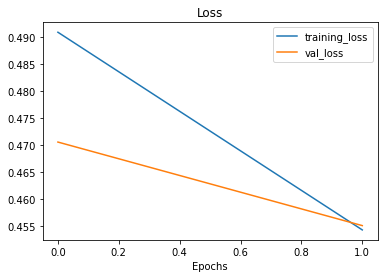

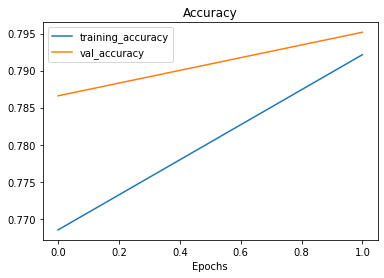

In [55]:
plot_loss_curves(model_1_history)

## Model_2 Feature Extraction Model

In [56]:
# Downloading Universal Sentence Encoder

import tensorflow_hub as hub

hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                     trainable = False,
                                     name = 'USE')

In [57]:
random_sent = random.choice(train_sentences)
print(f'Sentence before Embedding Layer: {random_sent}\n')
print(f'Sentence after Embedding Layer: {hub_embedding_layer([random_sent])}')

Sentence before Embedding Layer: finally finished hair and make up 

Sentence after Embedding Layer: [[-6.17582351e-02 -3.05817481e-02  8.96630716e-03 -1.93024017e-02
   4.16561887e-02 -4.22823802e-02  5.09334654e-02  1.59253590e-02
   2.23382376e-02  2.35281307e-02 -1.01050269e-02  8.51991549e-02
  -1.02405809e-02 -2.83730049e-02  5.27978390e-02  7.59642059e-03
   4.37902771e-02  4.08275090e-02 -2.54242774e-02  4.65269908e-02
  -3.85717936e-02  3.76378857e-02 -2.53366977e-02  6.36843815e-02
  -2.19355174e-03 -4.37317044e-02  1.42749799e-02  1.67147145e-02
   4.08198033e-03  6.07699454e-02  9.10930894e-03 -3.76681015e-02
  -3.94975170e-02  4.68218848e-02  8.28091707e-03  8.93257838e-03
   1.63118299e-02 -2.99346950e-02 -1.42378770e-02  1.43495379e-02
   3.14874053e-02 -4.83946353e-02 -3.51335332e-02 -5.04880957e-02
   3.46632153e-02 -5.66485040e-02 -4.00930345e-02 -7.17672631e-02
  -1.47473253e-02 -3.94383259e-02  7.31324777e-02  1.91473160e-02
  -2.39987615e-02 -2.65681334e-02 -5.5099

In [58]:
len(hub_embedding_layer([random_sent])[0]) # Length is 512 because the input is a variable length English text and the ouput is 512 dimensional feature vector

512

In [59]:
# Create model_2

inputs = layers.Input(shape = [], dtype = tf.string)
embedding = hub_embedding_layer(inputs)
x = layers.Dense(128, activation = 'relu', )(embedding)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])
# Fit the model
model_2_hist  = model_2.fit(train_dataset,
                            epochs = 3,
                            steps_per_epoch = int(0.1 * len(train_dataset)),
                            validation_data = val_dataset,
                            validation_steps = int(0.1 * len(val_dataset)),
                            callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss')])

Epoch 1/3
3612/3612 [==============================] - 43s 11ms/step - loss: 0.4666 - accuracy: 0.7788 - val_loss: 0.4589 - val_accuracy: 0.7804
Epoch 2/3
3612/3612 [==============================] - 40s 11ms/step - loss: 0.4461 - accuracy: 0.7893 - val_loss: 0.4480 - val_accuracy: 0.7869


In [60]:
model_2.evaluate(val_dataset)

6375/6375 [==============================] - 59s 9ms/step - loss: 0.4452 - accuracy: 0.7896


[0.44515013694763184, 0.7895686030387878]

In [61]:
model_2_pred_probs = model_2.predict(val_sentences)

In [62]:
model_2_preds = np.round(model_2_pred_probs)

In [63]:
model_2_results = calculate_results(y_pred = model_2_preds,
                                    y_true = tf.one_hot(val_labels, depth = 1))

In [64]:
RESULTS['model_2'] = model_2_results

In [65]:
RESULTS

{'model_0': {'accuracy': 77.05245098039217,
  'precision': 0.7728593367513529,
  'recall': 0.7705245098039216,
  'f1': 0.7700319671555375},
 'model_1': {'accuracy': 79.60392156862746,
  'precision': 0.7968518115815529,
  'recall': 0.7960392156862746,
  'f1': 0.7958992594625836},
 'model_2': {'accuracy': 78.95686274509805,
  'precision': 0.7903473928229957,
  'recall': 0.7895686274509804,
  'f1': 0.7894271376446821}}

## Model_3 with Character Level tokenisation

In [84]:
def split_char(text):
  return ' '.join(list(text))

In [86]:
train_chars = [split_char(sentence) for sentence in train_sentences]
val_chars =   [split_char(sentence) for sentence in val_sentences]
test_chars  = [split_char(sentence) for sentence in test_sentences]

train_labels_one_hot = tf.one_hot(train_labels, depth = 1)
val_labels_one_hot = tf.one_hot(val_labels, depth = 1)
test_labels_one_hot = tf.one_hot(test_labels, depth = 1)

In [68]:
char_len = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_len)
mean_char_lens

74.08697585378535

(array([1.86540e+04, 6.15180e+04, 9.05650e+04, 1.03559e+05, 1.07025e+05,
        1.15028e+05, 9.51020e+04, 8.55650e+04, 7.64450e+04, 6.94770e+04,
        6.96780e+04, 5.80320e+04, 5.74000e+04, 6.96270e+04, 7.18960e+04,
        5.59100e+03, 5.32000e+02, 1.12000e+02, 3.80000e+01, 3.10000e+01,
        2.20000e+01, 1.60000e+01, 1.70000e+01, 1.60000e+01, 1.80000e+01,
        1.30000e+01, 2.00000e+00, 1.00000e+00, 3.00000e+00, 2.00000e+00,
        1.00000e+00, 4.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([  6. ,  15.2,  24.4,  33.6,  42.8,  52. ,  61.2,  70.4,  79.6,
         88.8,  98. , 107.2, 116.4, 125.6, 134.8, 144. , 153.2, 162.4,
        171.6, 180.8, 190. , 199.2, 208.4, 217.6, 226.8, 236. , 245.2,
        254.4, 263.6, 272.8, 282. , 291.2, 300.4, 309.6, 318.8, 328. ,
        337.2, 346.4, 355.6, 364.8, 374. ]),
 <a list of 40 Patch objects>)

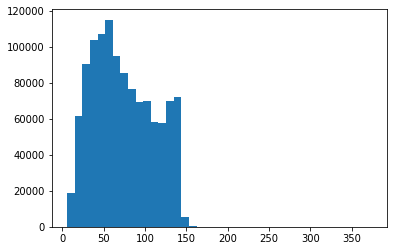

In [69]:
#  Check distribution of char

import matplotlib.pyplot as plt
plt.hist(char_len, bins = 40)

In [70]:
output_seq_len = int(np.percentile(char_len, 95))
output_seq_len

136

In [71]:
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [72]:
# Create Char lvl token vectorizer instance

NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                                    output_sequence_length = output_seq_len,
                                                    name = 'char_vectorizer')

In [73]:
char_vectorizer.adapt(train_char)

In [74]:
# Check char vocab stats

char_vocab = char_vectorizer.get_vocabulary()
print(f'Num of diff char {len(char_vocab)}')
print(f'5 most common char {char_vocab[:5]}')
print(f'5 least commom char {char_vocab[-5:]}')

Num of diff char 70
5 most common char ['', '[UNK]', 'e', 't', 'o']
5 least commom char ['¼', '\x83', '¡', '±', '\x84']


In [75]:
random_train_chars = random.choice(train_char)
print(f'Charified text: {random_train_chars}\n')
print(f'Len of rnaodm_train_char: {len(random_train_chars.split())}')
vectorized_char = char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n {vectorized_char}')
print(f'Len of vectorized chars:{len(vectorized_char[0])}')

Charified text: @ t s z c h e e t a h   c a n t   i n s t a l l   i t  

Len of rnaodm_train_char: 24
Vectorized chars:
 [[ 3  8 26 18 10  2  2  3  5 10 18  5  7  3  6  7  8  3  5 11 11  6  3  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Len of vectorized chars:136


In [76]:
# Create a char lvl embedding

char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 20,
                              mask_zero = True,
                              name = 'char_embed')

In [77]:
print(f'Charified text: {random_train_chars}\n')
embeded_char = char_embed(char_vectorizer([random_train_chars]))
print(f'Embeded Char : {embeded_char}\n')
print(f'Embeded Char Shape : {embeded_char.shape}')

Charified text: @ t s z c h e e t a h   c a n t   i n s t a l l   i t  

Embeded Char : [[[-0.03565852  0.00031142 -0.00142459 ... -0.00221638 -0.02614617
    0.02116254]
  [-0.00274616  0.01859485  0.00936334 ... -0.00472704 -0.04521214
   -0.00512213]
  [ 0.04342946 -0.00545766  0.00287702 ...  0.00455112  0.00175058
   -0.0059166 ]
  ...
  [ 0.02827984  0.04362451  0.01101021 ... -0.0189698  -0.04227493
   -0.00734507]
  [ 0.02827984  0.04362451  0.01101021 ... -0.0189698  -0.04227493
   -0.00734507]
  [ 0.02827984  0.04362451  0.01101021 ... -0.0189698  -0.04227493
   -0.00734507]]]

Embeded Char Shape : (1, 136, 20)


In [88]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [96]:
# Create the model_3

inputs = layers.Input(shape = (1,), dtype = tf.string)
char_vectors = char_vectorizer(inputs)
char_embeds = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size = 3, padding = 'same', activation = 'relu')(char_embeds)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss = 'binary_crossentropy',
                optimizer = "Adam",
                metrics = ['accuracy'])

# Fit the model

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
3612/3612 [==============================] - 36s 9ms/step - loss: 0.6182 - accuracy: 0.6512 - val_loss: 0.5804 - val_accuracy: 0.6951
Epoch 2/3
3612/3612 [==============================] - 21s 6ms/step - loss: 0.5688 - accuracy: 0.7029 - val_loss: 0.5624 - val_accuracy: 0.7062
Epoch 3/3
3612/3612 [==============================] - 18s 5ms/step - loss: 0.5604 - accuracy: 0.7100 - val_loss: 0.5548 - val_accuracy: 0.7127


In [97]:
model_3.evaluate(val_char_dataset)

6375/6375 [==============================] - 19s 3ms/step - loss: 0.5552 - accuracy: 0.7148


[0.5552313327789307, 0.7147940993309021]

In [98]:
model_3_pred_probs = model_3.predict(val_char_dataset)

In [99]:
model_3_preds = np.round(model_3_pred_probs)

In [100]:
model_3_results = calculate_results(y_true = tf.one_hot(val_labels, depth = 1),
                                    y_pred = model_3_preds)

In [101]:
RESULTS['model_3'] = model_3_results

In [102]:
RESULTS

{'model_0': {'accuracy': 77.05245098039217,
  'precision': 0.7728593367513529,
  'recall': 0.7705245098039216,
  'f1': 0.7700319671555375},
 'model_1': {'accuracy': 79.60392156862746,
  'precision': 0.7968518115815529,
  'recall': 0.7960392156862746,
  'f1': 0.7958992594625836},
 'model_2': {'accuracy': 78.95686274509805,
  'precision': 0.7903473928229957,
  'recall': 0.7895686274509804,
  'f1': 0.7894271376446821},
 'model_3': {'accuracy': 71.47941176470589,
  'precision': 0.7164804946255551,
  'recall': 0.7147941176470588,
  'f1': 0.7142384161504509}}

## Model_4 (Hybrid)

In [104]:
# Create token model
token_inputs = layers.Input(shape = [], dtype = tf.string)
token_embeds = hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(1, activation = 'relu')(token_embeds)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Create char model

char_inputs = layers.Input(shape = (1,), dtype = tf.string )
char_vectors = char_vectorizer(char_inputs)
char_embeds = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeds)
char_model =  tf.keras.Model(char_inputs, char_bi_lstm)

# Concatenate token and char

token_char_concat = layers.Concatenate()([token_model.output,
                                          char_model.output])

# Add output layer

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation = 'relu')(combined_dropout)
combined_dropout_2 = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(1, activation = 'sigmoid')(combined_dropout_2)

# Construct model

model_4 = tf.keras.Model(inputs = (token_model.input, char_model.input),
                         outputs = output_layer,
                         name = 'model_4_token_char')

In [105]:
# Compile the model

model_4.compile(loss = 'binary_crossentropy',
                optimizer = 'Adam',
                metrics = ['accuracy'])

In [108]:
# Create hybrid datasets for our hybrid model

train_char_token_sents = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_sents, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_sents = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_sents, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the model

model_4.fit(train_char_token_dataset,
            epochs = 3,
            steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
            validation_data = val_char_token_dataset,
            validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
3612/3612 [==============================] - 119s 31ms/step - loss: 0.6170 - accuracy: 0.6457 - val_loss: 0.5562 - val_accuracy: 0.7358
Epoch 2/3
1982/3612 [===============>..............] - ETA: 42s - loss: 0.5839 - accuracy: 0.6865